In [2]:
%reload_ext autoreload
%autoreload 2

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *


from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from matplotlib import pyplot

In [3]:
df = database_query("SELECT * FROM DATA")
df1 = df.copy()
df['time'] = df['timestamp'].apply(lambda x: x.value)
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,time
0,2,1,2020-06-25 15:21:46,28,15,628,0.962081,6812.007,3,8,1593098506000000000
1,2,1,2020-06-25 15:21:47,28,15,628,1.028834,6812.007,3,8,1593098507000000000
2,2,1,2020-06-25 15:21:47,28,15,628,0.648460,6812.007,3,8,1593098507000000000
3,2,1,2020-06-25 15:21:47,28,15,628,0.826075,6812.007,3,8,1593098507000000000
4,2,1,2020-06-25 15:21:50,26,15,626,1.753767,6812.007,3,8,1593098510000000000
...,...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,0.608769,97.531,1,7,1600785664000000000
2761247,8956,31,2020-09-22 14:41:05,19,16,659,0.743303,97.531,1,7,1600785665000000000
2761248,8956,31,2020-09-22 14:41:06,18,16,658,0.594138,97.531,1,7,1600785666000000000
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,28.712454,97.531,1,7,1600785671000000000


In [4]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

buffer = pd.DataFrame()
display_side_by_side(df.corr(), buffer, df.describe().round(1))

,ajokerta,node_id,x,y,grid_id,distance,kesto,dayofweek,current_hour,time
ajokerta,1.000000,0.994850,-0.001456,0.019703,0.019791,-0.017780,0.039851,-0.014831,-0.045813,0.118780
node_id,0.994850,1.000000,-0.000860,0.019203,0.019307,-0.017251,0.036887,-0.015505,-0.046848,0.100475
x,-0.001456,-0.000860,1.000000,-0.220780,-0.188150,-0.115991,0.004646,-0.014573,-0.036887,-0.032733
y,0.019703,0.019203,-0.220780,1.000000,0.999444,0.027589,0.008399,0.011712,0.014602,0.044298
grid_id,0.019791,0.019307,-0.188150,0.999444,1.000000,0.023818,0.008616,0.011296,0.013444,0.043489
distance,-0.017780,-0.017251,-0.115991,0.027589,0.023818,1.000000,0.008889,0.012734,0.017771,-0.003455
kesto,0.039851,0.036887,0.004646,0.008399,0.008616,0.008889,1.000000,0.047243,-0.010528,0.108686
dayofweek,-0.014831,-0.015505,-0.014573,0.011712,0.011296,0.012734,0.047243,1.000000,-0.151097,-0.014983
current_hour,-0.045813,-0.046848,-0.036887,0.014602,0.013444,0.017771,-0.010528,-0.151097,1.000000,0.031270
time,0.118780,0.100475,-0.032733,0.044298,0.043489,-0.003455,0.108686,-0.014983,0.031270,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29e018e610>,
      dtype=object)

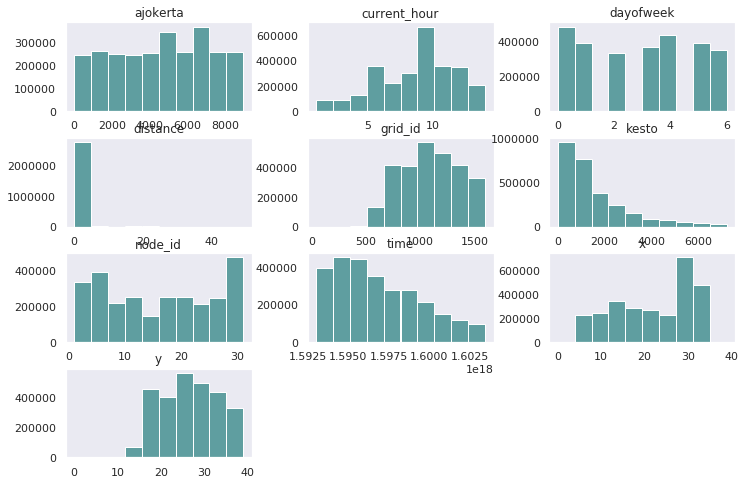

In [5]:
df.hist(grid = False, color="cadetblue",figsize=(12,8))

In [6]:
from scipy.stats import kurtosis, skew
from scipy import stats

#df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int)/ 10**9

grid_id_kurtosis = kurtosis(df['grid_id'], fisher=True)
timestamp_kurtosis = kurtosis(df['current_hour'], fisher=True)
#Skewness
grid_id_skew = skew(df['grid_id'])
timestamp_skew = skew(df['current_hour'])

display(f"grid_id kurtosis: {grid_id_kurtosis}")
display(f"grid_id skew: {grid_id_skew}")

display(f"timestamp kurtosis: {timestamp_kurtosis}")
display(f"timestamp skew: {timestamp_skew}")

display('grid_id')
display(stats.kurtosistest(df['grid_id']))
display(stats.skewtest(df['grid_id']))
display('timestamp')
display(stats.kurtosistest(df['current_hour']))
display(stats.skewtest(df['current_hour']))

'grid_id kurtosis: -1.151180705244877'

'grid_id skew: -0.05081608054965095'

'timestamp kurtosis: -0.5086986732637016'

'timestamp skew: -0.5394429168717015'

'grid_id'

KurtosistestResult(statistic=-1277.5503202030745, pvalue=0.0)

SkewtestResult(statistic=-34.45083044162736, pvalue=4.375845997295766e-260)

'timestamp'

KurtosistestResult(statistic=-235.67652582108144, pvalue=0.0)

SkewtestResult(statistic=-343.50629774966325, pvalue=0.0)

In [7]:
#df['timestamp'].apply(lambda x: time.mktime(x.timetuple()))
'''import datetime as dt
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp']=df['timestamp'].map(dt.datetime.toordinal)
df.dtypes'''
'''df1 = df.copy()
df.index = pd.to_datetime(df['timestamp'])
df = df.drop(['timestamp'], axis=1)'''

distances = df.groupby(['ajokerta'])['distance'].sum().to_dict()
df["distance"] = df['ajokerta'].map(distances)
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour,time
0,2,1,2020-06-25 15:21:46,28,15,628,582.077564,6812.007,3,8,1593098506000000000
1,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,1593098507000000000
2,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,1593098507000000000
3,2,1,2020-06-25 15:21:47,28,15,628,582.077564,6812.007,3,8,1593098507000000000
4,2,1,2020-06-25 15:21:50,26,15,626,582.077564,6812.007,3,8,1593098510000000000
...,...,...,...,...,...,...,...,...,...,...,...
2761246,8956,31,2020-09-22 14:41:04,19,16,659,93.673832,97.531,1,7,1600785664000000000
2761247,8956,31,2020-09-22 14:41:05,19,16,659,93.673832,97.531,1,7,1600785665000000000
2761248,8956,31,2020-09-22 14:41:06,18,16,658,93.673832,97.531,1,7,1600785666000000000
2761249,8956,31,2020-09-22 14:41:11,1,28,1121,93.673832,97.531,1,7,1600785671000000000


In [ ]:
#X = df['current_hour'].values
X = df['dayofweek'].values
y = df['grid_id'].values

plt.figure(figsize=(8, 6))
# Plot actual target against features
plt.scatter(X, y, c='steelblue',edgecolor='white', s=70)
plt.xlabel('current_hour')
plt.ylabel('grid_id')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = df[['dayofweek']]
y = df['grid_id']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
model = LinearRegression()         
model.fit(X_train, y_train)

print('coefficient:', model.coef_)
print('intercept:', model.intercept_)

#### Yhdessä tunnissa grid_id muuttuu 1.1 keskimääräisesti

In [ ]:
# 1593098506000000000
# 1593098506000
# 1500000000000
import datetime

# Date
dt = datetime.datetime(2020,6,30,15,0,0)
seq = dt.timestamp()
#seq = int(dt.strftime("%Y%m%d%H%M%S"))
seq
your_timestamp = 1593529200000
date = datetime.datetime.fromtimestamp(your_timestamp / 1e3)
date

In [ ]:
# klo 15 = 7
# klo 8 = 0
#time = seq * 1000
1593529200000
hour = 7
prediction = model.predict([[hour]])
#'2020-06-29 15:00:0'
print("Linear Predicted grid_id: ", prediction)

Text(0.5, 1.0, 'Linear regression model time vs. grid_id')

Text(0.5, 0, 'time')

Text(0, 0.5, 'grid_id')

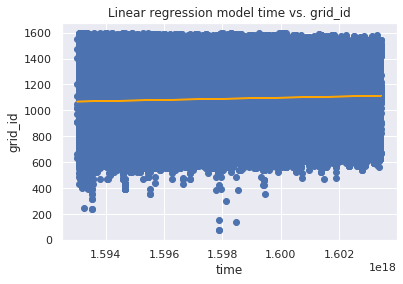

In [455]:
plt.scatter(X_test, y_test)
plt.plot(X_test, model.predict(X_test), color="orange")
plt.title("Linear regression model time vs. grid_id")
plt.xlabel('time')
plt.ylabel("grid_id")
plt.show()

In [421]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=1, random_state=0)
regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)

regressor.score(X_test, y_test)

hour = 7
reg_pred = regressor.predict([[hour]])
#'2020-06-29 15:00:0'
print("RamdomForest Predicted grid_id: ", reg_pred)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

0.0003474467058516284

RamdomForest Predicted grid_id:  [1083.32355787]


In [ ]:
plt.figure(figsize=(8, 6))

import matplotlib.cm as cm

days = ["maanantai","tiistai","keskiviikko","torstais","perjantai","lauantai","sunnuntai"]
colors=["red","orange","yellow","blue","cyan","deepskyblue","purple"]

plt.scatter(df['x'], df['y'], c='steelblue',edgecolor='white', s=50)
for i,j in zip(sorted(df['dayofweek'].unique()), days):
    prediction = model.predict([[i]])
    print("Predicted grid_id: ", prediction)
    plt.scatter(df[df['grid_id'] == round(prediction[0],0)]['x'], df[df['grid_id'] == round(prediction[0],0)]['y'], color=colors[i],edgecolors="black", marker="*", s=150, label=j)
    # Plot predicted target against features
    #plt.plot(df_15grids['x'].iloc[0], prediction,color='orange', lw=2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Ennustettu grid_id eri viikonpäiville")
    plt.legend()
plt.show()    

#### Klo 15, ennustettu grid_id on 1083

In [448]:
'''y = df['grid_id']
x = df[['dayofweek']]

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
'''
#model = LinearRegression()         
#model.fit(X_train, y_train)

print('coefficient:', model.coef_)
print('intercept:', model.intercept_)

y_predict = model.predict(X_test)

from sklearn.metrics import mean_absolute_error,mean_absolute_error, r2_score

model_r2 = r2_score(y_test, y_predict)
model_mse = mean_squared_error(y_test, y_predict)
model_mae = mean_absolute_error(y_test, y_predict)
model_rmse = math.sqrt(model_mse)

print("R2: ",model_r2)
print("MSE: ",model_mse)
print("MAE: ",model_mae)
print("RMSE: ",model_rmse)

prediction = model.predict([[0]])
#'2020-06-29 15:00:0'
predicted_value = prediction
print("Predicted grid_id: ", predicted_value)

"y = df['grid_id']\nx = df[['dayofweek']]\n\nX_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)\nprint(X_train.shape)\nprint(X_test.shape)\nprint(y_train.shape)\nprint(y_test.shape)\n"

coefficient: [1.18939596]
intercept: 1074.9035861490888
R2:  0.00017854926261973159
MSE:  68995.93264629171
MAE:  225.46809052058612
RMSE:  262.6707685417083
Predicted grid_id:  [1074.90358615]


Text(0.5, 1.0, 'Model residuals')

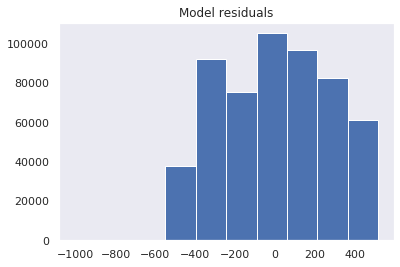

In [341]:
(y_test - y_predict).hist(grid=False)
plt.title("Model residuals")
plt.show()

Text(0.5, 1.0, 'Linear regression model dayofweek vs. grid_id')

Text(0.5, 0, 'day')

Text(0, 0.5, 'grid_id')

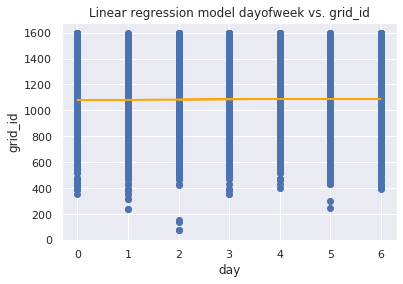

In [342]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_predict, color="orange")
plt.title("Linear regression model dayofweek vs. grid_id")
plt.xlabel('day')
plt.ylabel("grid_id")
plt.show()

In [ ]:
df_monday = df[df['grid_id'] == round(prediction[0],0)]
df_monday.head()

In [373]:
date = datetime.datetime.fromtimestamp(predicted_value / 1e9)
date

datetime.datetime(2020, 8, 16, 22, 47, 35)

In [457]:
df_feat = df_to_features(df)
#df_feat = df_feat[['timestamp', 'grid_id']]
df_feat

,ajokerta,node_id,grid_id,time,kesto,dayofweek,current_hour,distance,0,1,...,15,16,17,18,19,20,21,22,23,24
0,2,1,628,1593098506000000000,6812.007,3,8,582.077564,830,634,...,786,1091,1014,1065,869,829,1308,834,1189,866
1,3,1,630,1593101221000000000,1121.998,3,9,219.936854,894,710,...,709,775,830,1194,1428,1423,1114,1418,1091,954
2,4,1,631,1593105086000000000,769.999,3,10,349.979207,1154,753,...,1273,938,755,1149,634,715,1394,1034,1008,1570
3,5,1,628,1593114047000000000,265.000,3,12,207.363103,1274,1087,...,1153,708,1448,1113,748,1034,1193,1127,1128,1354
4,7,1,629,1593198044000000000,660.002,4,12,367.454784,1034,703,...,1035,954,1285,1167,1009,1127,952,708,827,669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7170,8948,31,629,1600451329000000000,645.998,4,10,156.599509,979,939,...,1254,1054,658,779,1413,1333,739,699,819,1494
7171,8950,31,1041,1600518802000000000,1239.000,5,5,579.244362,1134,1373,...,1408,1023,932,1016,700,1011,701,1413,1014,987
7172,8954,31,632,1600699655000000000,2287.001,0,7,234.295562,818,935,...,1167,1274,1366,985,1407,1026,974,1314,1220,1388
7173,8955,31,629,1600704077000000000,3745.999,0,9,156.742423,748,948,...,788,1506,658,708,868,828,1507,976,1544,1326


In [43]:
df_feat.max()

kesto       7198.998000
distance    7382.095116
dtype: float64

In [46]:
from scipy.stats import norm
from scipy.stats import zscore
import numpy as np
import pandas as pd

def outliers(df):
    z_scores = zscore(df)
    abs_z_scores = np.abs(z_scores)

    # Remove rows that have outliers in at least one column
    outliers = df[(abs_z_scores <= 2.5).all(axis=1)]

    # Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.
    filtered_entries = (abs_z_scores <= 2.5).all(axis=1)
    df_clean = df[filtered_entries]
    print(f"{'-'*30}\nOutliers")
    print("Data with outliers: ", len(df))
    print("Ouliers removed:    ", len(df) - len(df_clean))
    print("Data after: ", len(df_clean))
    return df_clean

df_clean = outliers(df_feat)
#df_clean['kesto'] = df_feat[~df_clean.isin(df_feat)].dropna()
#df_clean = df_clean[df_clean['distance'] <= 3000]
#df_clean = df_clean.drop(df_clean[df_clean['distance'] > 3000 ].index , inplace=True)
#df_clean
df_clean[df_clean['distance'] < 3000 ]
df_clean.max()

------------------------------
Outliers
Data with outliers:  7175
Ouliers removed:     375
Data after:  6800


,kesto,distance
1,1121.998,219.936854
2,769.999,349.979207
3,265.000,207.363103
4,660.002,367.454784
5,877.001,511.475758
...,...,...
7170,645.998,156.599509
7171,1239.000,579.244362
7172,2287.001,234.295562
7173,3745.999,156.742423


kesto       5111.999000
distance     634.349261
dtype: float64

In [466]:
from sklearn.linear_model import LinearRegression

X = df_feat[['time']].values                          # Assign matrix X
y = df_feat['grid_id'].values                             # Assign vector y

sort_idx = X.flatten().argsort()                  # Sort X and y by ascending values of X
X = X[sort_idx]
y = y[sort_idx]

model = LinearRegression()         
model.fit(X, y)

y_pred = model.predict(X)
print('predicted response:', y_pred, sep='\n')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

predicted response:
[620.19867584 620.60071738 620.60431637 ... 684.85670919 684.85988477
 685.16722538]


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'grid_id')

Text(0, 0.5, 'time')

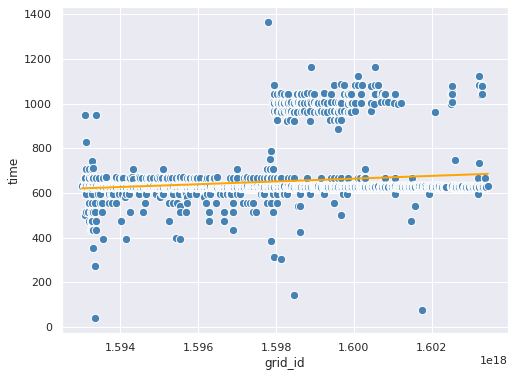

In [467]:
plt.figure(figsize=(8, 6))
# Plot actual target against features
plt.scatter(X, y, c='steelblue',edgecolor='white', s=70)
# Plot predicted target against features
plt.plot(X, y_pred,color='orange', lw=2)
plt.xlabel('grid_id')
plt.ylabel('time')
plt.show()

In [110]:
rmse = (np.sqrt(mean_squared_error(y, y_pred)))
r2 = r2_score(y, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print('Prediction: %d' % y_pred[0])
r_sq = model.score(X,y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

The model performance for testing set
--------------------------------------
RMSE is 1112.976427342934
R2 score is 0.02734051109450475
Prediction: 928
coefficient of determination: 0.02734051109450475
intercept: 850.8740662632092
slope: [1.86228434]


'Creates a polynomial regression model for the given degree'

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The model performance for the training set
-------------------------------------------
RMSE of training set is 1095.9144577724944
R2 score of training set is 0.023514319501392267


The model performance for the test set
-------------------------------------------
RMSE of test set is 1162.875307682395
R2 score of test set is -0.02846669850130845


<Figure size 576x432 with 0 Axes>

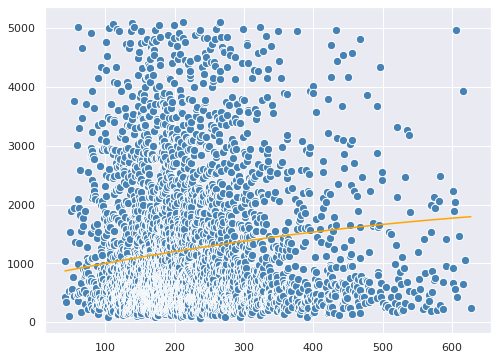

In [159]:
import operator

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(0)
#x = 2 - 3 * np.random.normal(0, 1, 20)
#y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

#x=y.reshape(-1, 1)
#Y=y_pred

from sklearn.preprocessing import PolynomialFeatures


"Creates a polynomial regression model for the given degree"
  
poly_features = PolynomialFeatures(degree=2)
  
# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
  
# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)
  
# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)
  
# predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)
  
# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
r2_test = r2_score(Y_test, y_test_predict)
  
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
  
print("\n")
print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

#poly_model = LinearRegression()
#poly_model.fit(x, y)

plt.figure(figsize=(8,6))

plt.scatter(X_test, Y_test, c='steelblue',edgecolor='white', s=70)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_test,y_test_predict), key=sort_axis)
x2, y_poly_pred = zip(*sorted_zip)
plt.plot(x2, y_poly_pred, color='orange')

In [129]:
matka = [420,420,420]
test_pred = model.predict([matka])
print(f"Matka joka oli {matka}, kesti {test_pred}")

Matka joka oli [420, 420, 420], kesti [1232.33127096]


In [227]:
from scipy.stats import norm
from scipy.stats import zscore

x2 = X.flatten() 
df1 = pd.DataFrame({'distance':x2,'kesto':y,'y_pred':y_pred})
df1

z_scores = zscore(df1)
abs_z_scores = np.abs(z_scores)
    
# Remove rows that have outliers in at least one column
outliers = df1[(abs_z_scores <= 2.5).all(axis=1)]
    
# Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.
filtered_entries = (abs_z_scores <= 2.5).all(axis=1)
df_clean = df1[filtered_entries]
print(f"{'-'*30}\nOutliers")
print("Data with outliers: ", len(df1))
print("Ouliers removed:    ", len(df1) - len(df_clean))
print("Data after: ", len(df_clean))
df_clean

,distance,kesto,y_pred
0,41.930032,1967.002,1192.579849
1,42.182979,1494.999,1192.943834
2,44.007645,118.000,1195.569492
3,44.516110,370.999,1196.301163
4,46.222940,141.000,1198.757257
...,...,...,...
7170,2311.912277,3810.583,4459.038300
7171,2316.685810,6902.998,4465.907318
7172,2472.797002,5132.998,4690.548161
7173,2824.853767,4001.998,5197.150712


------------------------------
Outliers
Data with outliers:  7175
Ouliers removed:     375
Data after:  6800


,distance,kesto,y_pred
0,41.930032,1967.002,1192.579849
1,42.182979,1494.999,1192.943834
2,44.007645,118.000,1195.569492
3,44.516110,370.999,1196.301163
4,46.222940,141.000,1198.757257
...,...,...,...
7072,619.029463,2637.000,2023.014236
7073,621.147475,1029.999,2026.062013
7074,626.557706,760.402,2033.847225
7075,626.922230,1781.999,2034.371768


In [126]:
rmse = (np.sqrt(mean_squared_error(y, y_pred)))
r2 = r2_score(y, y_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print('Prediction: %d' % y_pred[0])
r_sq = model.score(x_poly,y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

The model performance for testing set
--------------------------------------
RMSE is 1112.976427342934
R2 score is 0.02734051109450475
Prediction: 928
coefficient of determination: 0.05244580517905317
intercept: 1168.8951651604314
slope: [ 0.00000000e+00  1.51068468e-01 -3.01206623e-05]


In [133]:
from numpy import mean
from numpy import std
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import BaggingRegressor


bagmodel = BaggingRegressor(base_estimator=SVR(),
                         n_estimators=10, random_state=0)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, error_score='raise')

print('MAE: ',mean(n_scores),' ', std(n_scores))

bagmodel.fit(X, y)
print("Score: ",model.score(X, y))

yhat = bagmodel.predict(X)
print('Prediction: %d' % yhat[0])

MAE:  -873.9434378008483   19.341064728201804


BaggingRegressor(base_estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                    epsilon=0.1, gamma='scale', kernel='rbf',
                                    max_iter=-1, shrinking=True, tol=0.001,
                                    verbose=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
                 random_state=0, verbose=0, warm_start=False)

Score:  0.02734051109450475
Prediction: 748


In [140]:
from sklearn.ensemble import AdaBoostRegressor

regr1 = DecisionTreeRegressor(max_depth=4)

regr2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=0)

n_scores = cross_val_score(regr1, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, error_score='raise')
n_scores2 = cross_val_score(regr2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, error_score='raise')

print('MAE 1: ',mean(n_scores),' ', std(n_scores))
print('MAE 2: ',mean(n_scores2),' ', std(n_scores2))

regr1.fit(X, y)
regr2.fit(X, y)

print("Score 1: ",regr1.score(X, y))
print("Score 2: ",regr2.score(X, y))


y_1 = regr1.predict(X)
y_2 = regr2.predict(X)

prediction1 = regr1.predict([[420]])
prediction2 = regr2.predict([[420]])

print('Prediction 1: %d' % prediction1[0])
print('Prediction 2: %d' % prediction2[0])

MAE 1:  -879.2790148414276   20.560067996533782
MAE 2:  -1123.202394642216   83.9750935694617


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                  

Score 1:  0.03930439972322197
Score 2:  -0.3913250484117341
Prediction 1: 1545
Prediction 2: 2134


In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.5, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3400, 1)
(3400, 1)
(3400,)
(3400,)


In [141]:
from numpy import mean
from numpy import std
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import BaggingRegressor


model = BaggingRegressor(base_estimator=SVR(),
                         n_estimators=10, random_state=0)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, error_score='raise')

#print('MAE: ',mean(n_scores),' ', std(n_scores))

yhat = model.predict(X)
print('Prediction: %d' % yhat[0])

plt.figure(figsize=(16, 8))
# Plot actual target against features
plt.scatter(X, y, c='steelblue',edgecolor='white', s=70)
# Plot predicted target against features
plt.plot(X, yhat,color='orange', lw=2)
plt.xlabel('kesto')
plt.ylabel('timestamp')
plt.show()

NotFittedError: This BaggingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

>Linear Regression -779.336 (107.489)
>Decision Tree -817.711 (114.314)
>AdaBoost -950.926 (127.742)
>Bagging -701.593 (121.219)
>Stacking -962.655 (161.252)
>voting -806.477 (115.791)


{'whiskers': [<matplotlib.lines.Line2D at 0x7faf38355550>,
 'caps': [<matplotlib.lines.Line2D at 0x7faf38355f90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faf3834a890>,
 'medians': [<matplotlib.lines.Line2D at 0x7faf3835aa10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf3834a8d0>,
 'means': [<matplotlib.lines.Line2D at 0x7faf3835af10>,
  <matplotlib.lines.Line2D at 0x7faf383144d0>]}

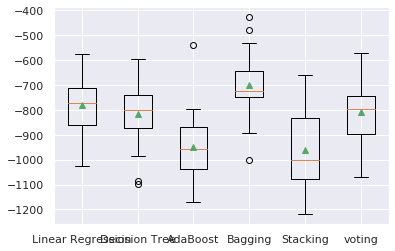

In [204]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from matplotlib import pyplot

# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42, max_iter=2000))]
    models.append(('Linear Regression', LinearRegression()))
    models.append(('Decision Tree', DecisionTreeRegressor(max_depth=4)))
    models.append(('AdaBoost', AdaBoostRegressor(DecisionTreeRegressor(max_depth=4,random_state=0))))
    models.append(('Bagging', BaggingRegressor(base_estimator=SVR(),n_estimators=10,random_state=0)))
    models.append(('Stacking', StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))))
    # define the voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

# get a list of models to evaluate
def get_models():
    models = dict()
    estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42, max_iter=2000))]
    models['Linear Regression'] = LinearRegression()
    models['Decision Tree'] = DecisionTreeRegressor(max_depth=4)
    models['AdaBoost'] = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4,random_state=0))
    models['Bagging'] = BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
    models['Stacking'] = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))
    models['voting'] = get_voting()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=0,
                                                       splitter='best'),
                  lea

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, 'kesto')

Text(0, 0.5, 'timestamp')

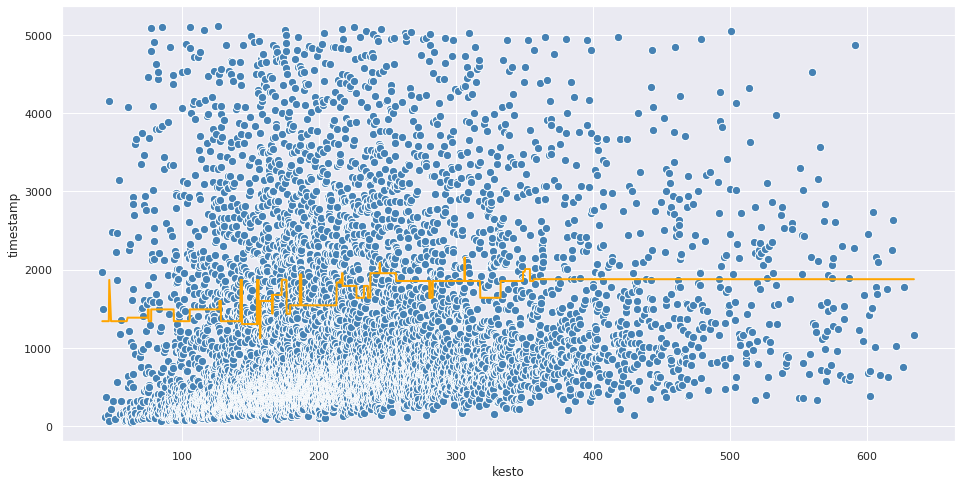

In [235]:
from sklearn.ensemble import RandomForestRegressor

Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4,random_state=0))     
Ada.fit(X, y)
ada_pred = Ada.predict(X)

plt.figure(figsize=(16, 8))
# Plot actual target against features
plt.scatter(X, y, c='steelblue',edgecolor='white', s=70)
# Plot predicted target against features
plt.plot(X, ada_pred,color='orange', lw=2)
plt.xlabel('kesto')
plt.ylabel('timestamp')
plt.show()

In [237]:
matka = [69, 420,666,1000,765]
for i in matka:
    test_pred = Ada.predict([[i]])
    print(f"Matka joka oli {i}, kesti {test_pred}") # 6812.007

Matka joka oli 69, kesti [1387.29048193]
Matka joka oli 420, kesti [1878.74658898]
Matka joka oli 666, kesti [1878.74658898]
Matka joka oli 1000, kesti [1878.74658898]
Matka joka oli 765, kesti [1878.74658898]
